## This workbook used weekly fuel price data from MBIE and quarterlyCPI data from StatsNZ to calculate inflation adjusted fuel prices

In [3]:
library(tidyverse)
library(readxl)
library(magrittr)
library(lubridate)

In [4]:
#import cpi data
cpi_raw <- read_csv("cpi_raw_data.csv")
glimpse(cpi_raw)
#rename the index number column
colnames(cpi_raw)[6] = "Index_number"#

Parsed with column specification:
cols(
  Level = col_character(),
  `Series ref: CPIQ` = col_character(),
  Description = col_character(),
  Quarter = col_character(),
  Weight = col_double(),
  `Index number` = col_double()
)


Observations: 8,198
Variables: 6
$ Level              <chr> "All groups", "Group", "Group", "Group", "Group"...
$ `Series ref: CPIQ` <chr> "SE9A", "SE901", "SE902", "SE903", "SE904", "SE9...
$ Description        <chr> "All groups CPI", "Food", "Alcoholic beverages a...
$ Quarter            <chr> "2006Q2", "2006Q2", "2006Q2", "2006Q2", "2006Q2"...
$ Weight             <dbl> 100.00, 17.39, 7.20, 4.75, 20.02, 5.49, 5.23, 17...
$ `Index number`     <dbl> 815.6607, 759.8784, 628.5355, 1002.0040, 694.444...


In [5]:
# The CPI data has an entire breakdown of every basket in the CPI for all quarters
#We only want the rows that are tagged with "all groups" so need to filter those rows
#and select the columns with quarter and index values

cpi_raw %<>%
        select(Level,Quarter,Index_number) %>%
        filter(Level == "All groups") %>%
        select(-Level)
tail(cpi_raw)

Quarter,Index_number
2017Q2,1000.000
2017Q3,1004.894
2017Q4,1006.000
2018Q1,1011.000
2018Q2,1015.000
2018Q3,1024.000


In [6]:
#import fuel price data
fuel_price_raw <- read_csv("fuel_price_raw.csv")
tail(fuel_price_raw)

Parsed with column specification:
cols(
  .default = col_double(),
  Week_ending_Friday = col_character(),
  Week_number = col_character(),
  Status = col_character()
)
See spec(...) for full column specifications.


Week_ending_Friday,Week_number,Status,Dubai_crude_USD.p.bbl,NZ_US_exrate,Dubai_crude_NZD.p.bbl,Diesel_importer_cost_NZc.p.l,Diesel_ETS_NZc.p.l,Diesel_GST_NZc.p.l,Diesel_taxes_NZc.p.l,...,Petrol_importer_cost_NZc.p.l,Petrol_ETS_NZc.p.l,Petrol_GST_NZc.p.l,Petrol_taxes_NZc.p.l,Petrol_price_excl_taxes_NZc.p.l,Petrol_main_port_price_NZc.p.l,Petrol_discounted_retail_price_NZc.p.l,Petrol_importer_margin_NZc.p.l,Petrol_margin_trend_NZc.p.l,Diesel_main_port_price_excl_taxes_NZc.p.l
31/08/2018,2018w35,Provisional,75.44,0.66816,112.9071,91.21200,5.34,20.42703,21.05703,...,87.65434,4.62,28.48584,94.96984,118.8016,232.9000,218.3914,31.14723,29.69536,144.6263
7/09/2018,2018w36,Provisional,75.42,0.65854,114.5261,93.95743,5.34,20.72517,21.35517,...,90.05543,4.62,28.70944,95.19344,120.2923,234.6143,220.1057,30.23682,29.71737,146.6139
14/09/2018,2018w37,Provisional,76.45,0.65374,116.9425,94.38145,5.34,21.06057,21.69057,...,91.28716,4.62,29.15664,95.64064,123.2736,238.0429,223.5343,31.98646,29.73938,148.8499
21/09/2018,2018w38,Provisional,76.76,0.66056,116.2044,93.59333,5.34,21.17237,21.80237,...,91.13291,4.62,29.26844,95.75244,124.0190,238.9000,224.3914,32.88605,29.76139,149.5952
28/09/2018,2018w39,Provisional,79.90,0.66514,120.1251,96.11001,5.34,21.43324,22.06324,...,92.28721,4.62,29.52931,96.01331,125.7581,240.9000,226.3914,33.47089,29.78342,151.3343
5/10/2018,2018w40,Provisional,83.14,0.65568,126.7997,101.23679,5.34,21.42840,22.05840,...,95.72762,4.62,30.22344,100.20744,126.8856,246.6143,231.7131,31.15799,29.80545,152.8250


In [7]:
#Select only the date, petrol price, crude oil price, and petrol taxes
fuel_price <- fuel_price_raw %>%
    select(Week_ending_Friday, Petrol_discounted_retail_price_NZc.p.l, Dubai_crude_USD.p.bbl, Petrol_taxes_NZc.p.l )

#Rename the columns to make the names shorter! 

new_names = c("Week_ending_Friday", "Petrol_price_cpl","Oil_price_bbl","Petrol_tax_cpl")
names(fuel_price) <- new_names

#The inflation data is reported by quarter so turn the date stamps
# into quarterly labels that match the quarter labels in the index data which are in the form "20XXQX"
fuel_price %<>%
    mutate(Week = dmy(Week_ending_Friday)) %>%   #Turn the date strings into a format that lubridate can use
    mutate(Quarter = paste0(year(Week),"Q",quarter(Week)))   #extract the year from the date and paste it together with the quarter in that year

#Only want the price and the quarter for the price
#since we are joining with the inflation data
fuel_price <- fuel_price %>%
        select(Quarter,Petrol_price_cpl, Oil_price_bbl,Petrol_tax_cpl)

head(fuel_price)

Quarter,Petrol_price_cpl,Oil_price_bbl,Petrol_tax_cpl
2004Q2,114.5,32.10,54.7
2004Q2,113.0,32.65,54.5
2004Q2,117.3,33.38,55.0
2004Q2,121.9,34.41,55.5
2004Q2,121.3,35.77,55.4
2004Q2,123.9,35.03,55.7


In [15]:
#Since the fuel price data is weekly, several weeks have been renamed with the same quarterly
#label. Before joining the fuel price data with the inflation data we take an average
#of the fuel price/barrel price/tax for each quarter
average_fuel_price <- fuel_price %>%
    group_by(Quarter) %>%
    summarise(Average_petrol_price_cpl = mean(Petrol_price_cpl), Average_barrel_price = mean(Oil_price_bbl), Average_tax = mean(Petrol_tax_cpl))
head(average_fuel_price)


Quarter,Average_petrol_price_cpl,Average_barrel_price,Average_tax
2004Q2,119.1600,33.90500,55.20000
2004Q3,118.6923,35.91615,55.15385
2004Q4,118.7286,35.57071,55.17143
2005Q1,118.1500,40.82167,55.08333
2005Q2,126.4077,47.27154,60.63077
2005Q3,142.9357,55.19571,63.49286


In [16]:
#Join the price and cpi data (by Quarter)
#only joins the tables where we have both the cpi and price
#data for that quarter
fuel_inflation <- inner_join(average_fuel_price,cpi_raw, by = "Quarter")

#There are 
#Index Number is the inflation index
fuel_inflation %>% head()

Quarter,Average_petrol_price_cpl,Average_barrel_price,Average_tax,Index_number
2006Q2,167.7846,64.77308,67.03077,815.6607
2006Q3,166.0615,65.87077,66.82308,821.3703
2006Q4,140.9231,57.23462,64.01538,819.7390
2007Q1,142.3077,55.47154,64.18462,823.8173
2007Q2,153.8231,64.67154,66.09231,831.9739
2007Q3,156.6000,70.02538,67.91538,836.0522


Saving 6.67 x 6.67 in image


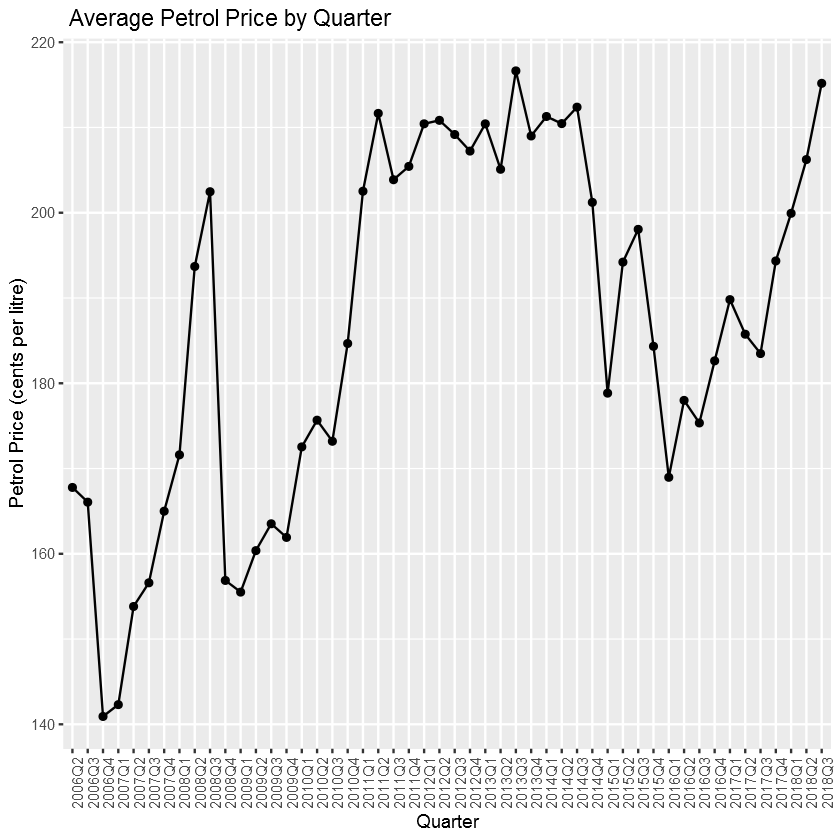

In [22]:
#Plot fuel price over time
#Note since the quarterly figures are averaged from weekly data and 
#we don't have the inflation figures for quarter 4 yet this graph doesn't
#include the new fuel taxes from the 1st October 2018

fuel_inflation %>%
    ggplot( aes(x = Quarter, y = Average_petrol_price_cpl, group = 1) )+geom_line() + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    ggtitle(" Average Petrol Price by Quarter")+
    xlab("Quarter")+ylab ("Petrol Price (cents per litre)")

ggsave("pump_price.png")



Quarter,Average_petrol_price_cpl,Average_barrel_price,Average_tax,Index_number,Inflation_adjusted_price,Inflation_adjusted_barrel,Inflation_adjusted_tax
2006Q2,167.7846,64.77308,67.03077,815.6607,167.7846,64.77308,67.03077
2006Q3,166.0615,65.87077,66.82308,821.3703,164.9072,65.41288,66.35857
2006Q4,140.9231,57.23462,64.01538,819.7390,140.2220,56.94987,63.69690
2007Q1,142.3077,55.47154,64.18462,823.8173,140.8987,54.92232,63.54912
2007Q2,153.8231,64.67154,66.09231,831.9739,150.8069,63.40347,64.79638
2007Q3,156.6000,70.02538,67.91538,836.0522,152.7805,68.31745,66.25891


Saving 6.67 x 6.67 in image


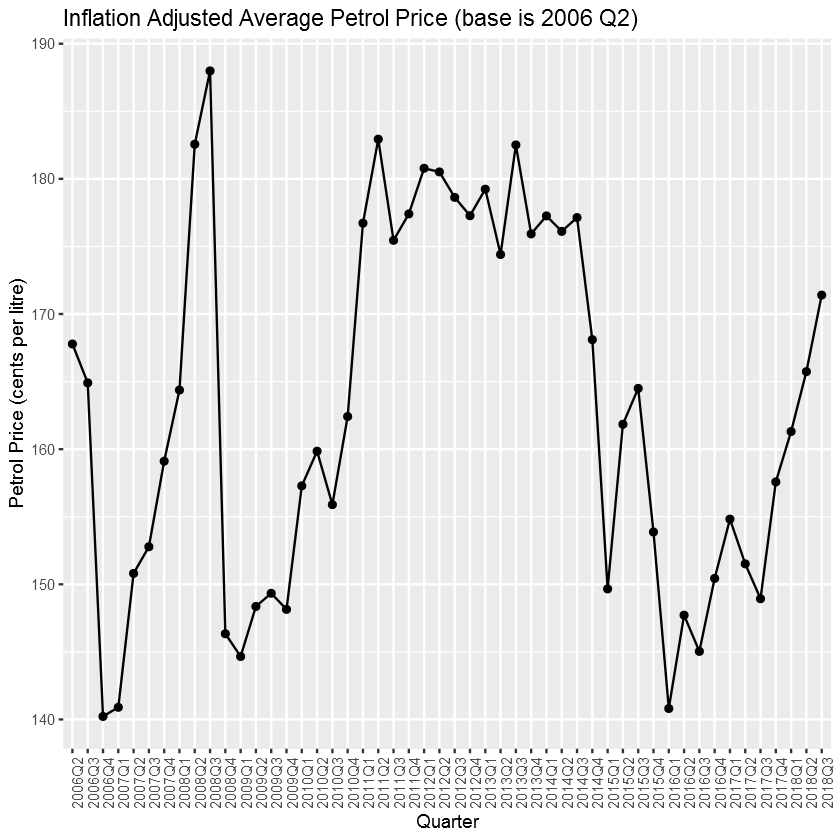

In [24]:
#Want to adjust the fuel price for inflation
#so take the base level from 2006 Q2 - the first quarter in the table

base_index = fuel_inflation[[5]][1]

#add a column to the table for inflation adjusted quarterly average pump price, barrel price and tax
fuel_inflation %<>% mutate(Inflation_adjusted_price = Average_petrol_price_cpl * base_index/ Index_number)
fuel_inflation %<>% mutate(Inflation_adjusted_barrel = Average_barrel_price * base_index/ Index_number)
fuel_inflation %<>% mutate(Inflation_adjusted_tax =Average_tax * base_index/ Index_number)
fuel_inflation %>% head()

#Plot the inflation adjusted price data
fuel_inflation%>%
      ggplot( aes(x = Quarter, y = Inflation_adjusted_price, group = 1) )+geom_point() + geom_line() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        ggtitle("Inflation Adjusted Average Petrol Price (base is 2006 Q2)")+
        xlab("Quarter")+ylab("Petrol Price (cents per litre)")

ggsave("petrol_price_inflation_adjusted.png")

Saving 6.67 x 6.67 in image


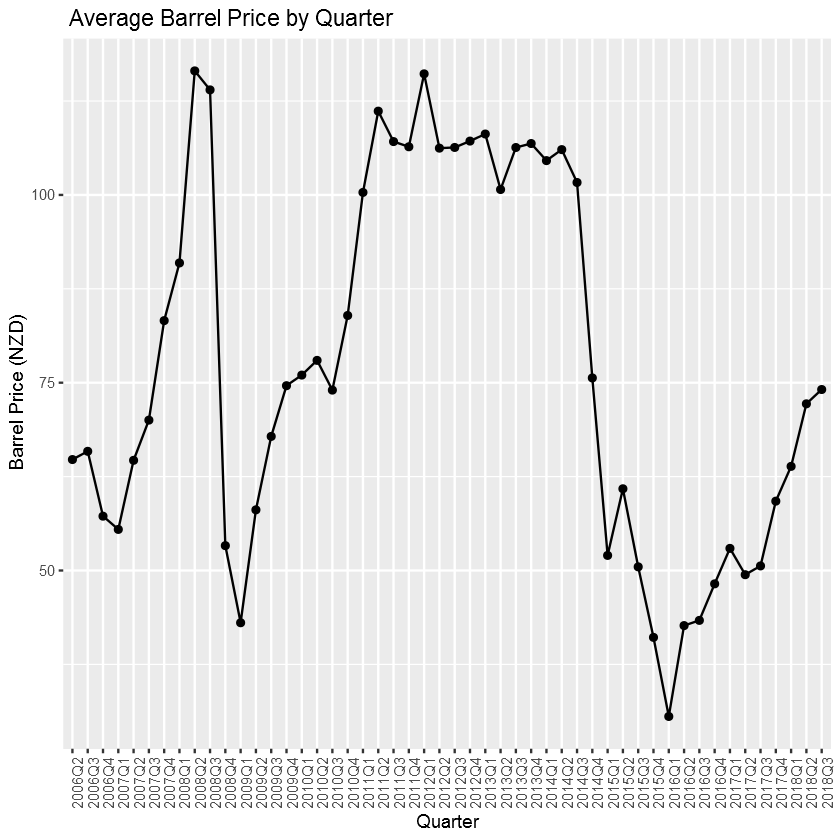

In [29]:
fuel_inflation %>%
    ggplot( aes(x = Quarter, y = Average_barrel_price, group = 1) )+geom_line() + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    ggtitle(" Average Barrel Price by Quarter")+
    xlab("Quarter")+ylab ("Barrel Price (NZD)")

ggsave("barrel_price.png")

Saving 6.67 x 6.67 in image


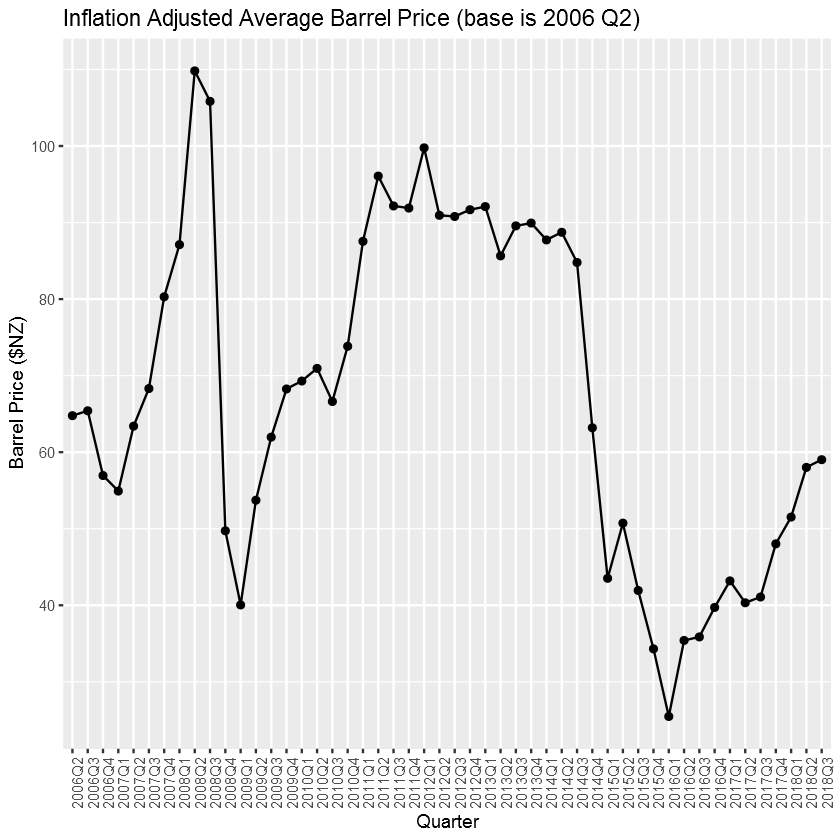

In [30]:
#Plot the inflation adjusted price data
fuel_inflation%>%
      ggplot( aes(x = Quarter, y = Inflation_adjusted_barrel, group = 1) )+geom_point() + geom_line() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        ggtitle("Inflation Adjusted Average Barrel Price (base is 2006 Q2)")+
        xlab("Quarter")+ylab("Barrel Price ($NZ)")

ggsave("barrel_price_inflation_adjusted.png")

Saving 6.67 x 6.67 in image


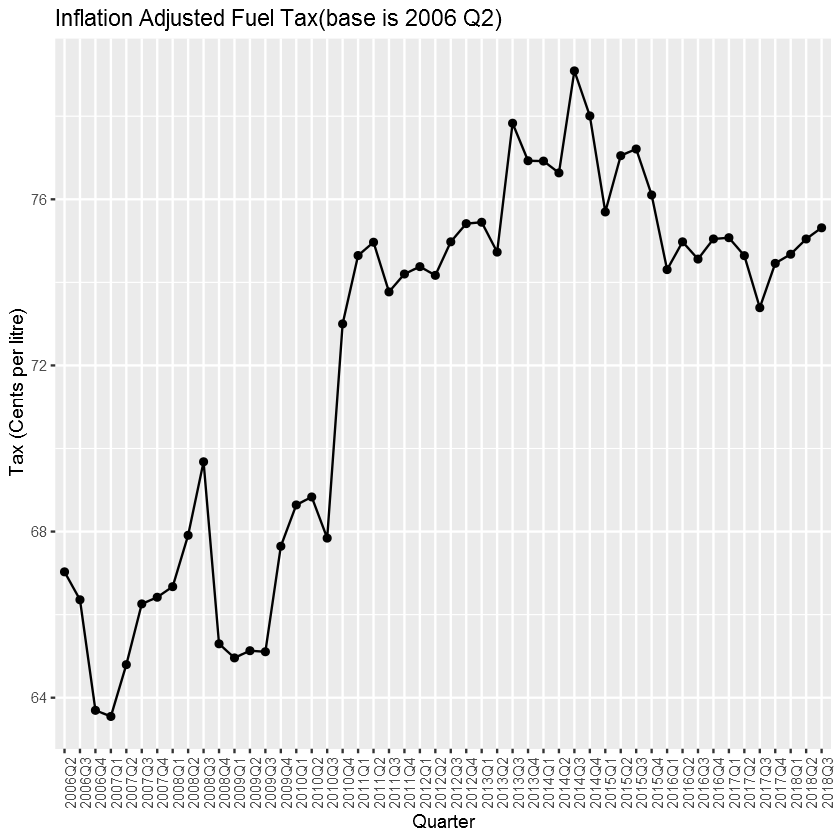

In [33]:
fuel_inflation%>%
      ggplot( aes(x = Quarter, y = Inflation_adjusted_tax, group = 1) )+geom_point() + geom_line() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        ggtitle("Inflation Adjusted Fuel Tax(base is 2006 Q2)")+
        xlab("Quarter")+ylab("Tax (Cents per litre)")

ggsave("inflation_adjusted_tax.png")

Saving 6.67 x 6.67 in image


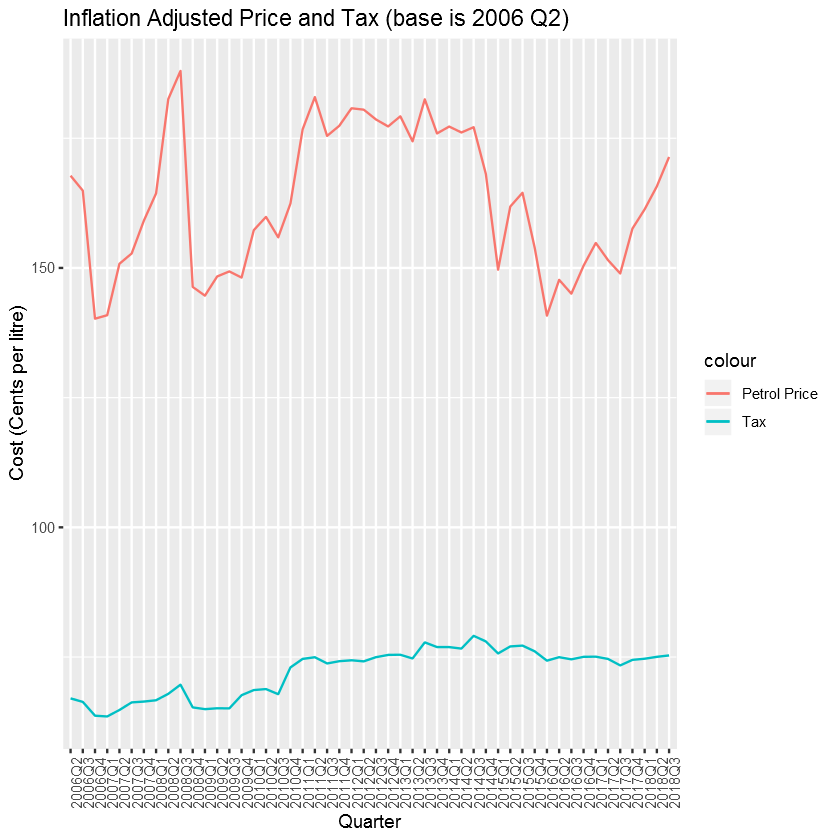

In [35]:
#A lot of the media coverage around fuel prices has been around petrol taxes
#When we adjust for inflation and plot the fuel price and tax we can
#see that volatility in petrol prices is not due to taxes, which
#have remained flat, in real terms until they went up on October 1st this year.

fuel_inflation%>%
      ggplot( aes(x = Quarter) )+

geom_line(aes(y = Inflation_adjusted_price, colour  = "Petrol Price", group = 1))+
geom_line(aes(y = Inflation_adjusted_tax, colour = "Tax", group = 2) )+
theme(axis.text.x = element_text(angle = 90, hjust = 1))+
       ggtitle("Inflation Adjusted Price and Tax (base is 2006 Q2)")+
      xlab("Quarter")+ylab("Cost (Cents per litre)")

ggsave("inflation_adjusted_tax_price_comparison.png")

In [39]:
#Save the dataset as a CSV
write_csv(fuel_inflation, "Quarterly_fuel_price_real_and_nominal.csv")